1. Epoch: 30
2. Batch= 128
3. lr= 0.000005
4. choose threshold applied

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [114]:
# Import all the necessary Library 
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset, random_split
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [115]:
path_cropped_lfw_folder='./gdrive/MyDrive/Datasets/Cropped_lfw_correct'
path_lfw_folder='./gdrive/MyDrive/Datasets'

In [116]:
def count_parameters(model):
    temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model architecture:\n\n', model)
    print(f'\nThe model has {temp:,} trainable parameters')

def save_checkpoint(save_path, model, optimizer, val_acc):
    if save_path==None:      
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),                    
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_accuracy': val_acc}

    torch.save(state_dict, save_path)

    print(f'Model saved to ==> {save_path}')

def load_checkpoint(model, optimizer,save_path):
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_acc = state_dict['val_accuracy']
    print(f'Model loaded from <== {save_path}')
    
    return val_acc

In [117]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [153]:
class Config():
    training_dir = "./gdrive/MyDrive/Datasets/Cropped_lfw_correct"
    testing_dir = "./gdrive/MyDrive/Datasets/Cropped_lfw_correct"
    validation_dir="./gdrive/MyDrive/Datasets/Cropped_lfw_correct"
    train_batch_size = 128
    train_number_epochs = 30
    training_txt="./gdrive/MyDrive/Datasets/LWF_DATASET/pairsDevTrainMod.txt"
    testing_txt="./gdrive/MyDrive/Datasets/LWF_DATASET/pairsDevValidMod.txt"

In [154]:
class SiameseNetworkDataset():
    
    def __init__(self,training_txt=None,training_dir=None,transform=None):
        self.training_dir = training_dir    
        self.transform = transform
        
        with open(training_txt) as f:
          lines=f.readlines()
          self.training_pairs=[  line.split()       for line in lines  ] 
          for i in range(len(self.training_pairs)):
            self.training_pairs[i][2]=int(self.training_pairs[i][2])
            if self.training_pairs[i][2]==1:                                     # 0 for similar pairs and 1 for dissimilar pairs
              self.training_pairs[i][2]=0
            else:
              self.training_pairs[i][2]=1   

    def __getitem__(self,index):
        
        # getting the image path
        image_pair= self.training_pairs[index]
        image1_path=os.path.join(self.training_dir,image_pair[0])
        image2_path=os.path.join(self.training_dir,image_pair[1])
        
        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        
        # Apply image transformations
        if self.transform :
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int( image_pair[2] )],dtype=np.float32))
    
    def __len__(self):
        return len(self.training_pairs)

In [155]:
class Identity(nn.Module):
  def __init__(self):
    super(Identity,self).__init__()
  
  def forward(self,x):
    return x

In [156]:
class SiameseNetwork(nn.Module):           # ip=(128,128,3)
  def __init__(self):
    super(SiameseNetwork,self).__init__()

    self.model_vgg16=torchvision.models.vgg16(pretrained=True)                         
    
    # make the grads off for earlier layers(0 to 23 layers)
    frozen_layers=nn.Sequential(   *(list(self.model_vgg16.children())[0][0:24] )   ) 
    
    for param in frozen_layers.parameters(): 
      param.requires_grad = False

    # self.num_ftrs=self.model_vgg16.features.out_features
  
    self.model_vgg16.avgpool= Identity()

    self.model_vgg16.classifier= nn.Sequential(
        nn.Linear(512*4*4,512),   ### for 128,128,3  ip size
        nn.ReLU(inplace=True),
        nn.Linear(512,512),
        nn.ReLU(inplace=True),
        nn.Linear(512,512),
        nn.ReLU(inplace=True)
    )


  def forward(self,x1,x2):
    x1= self.model_vgg16(x1)            
    x2= self.model_vgg16(x2)        
    
    return x1,x2

In [157]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=1.0):
      super(ContrastiveLoss, self).__init__()
      self.margin = margin

    def forward(self, output1,output2, label):                                                
      dist = F.pairwise_distance(output1, output2)
      loss= torch.mean(  (1- label) * torch.pow(dist, 2) + (label) * torch.pow( torch.clamp(   self.margin - dist ,  min=0.0  ) , 2)   )
      return loss

In [158]:
if torch.cuda.is_available():
  device='cuda:0'
  print('Running on gpu')
else:
  device='cpu'
  print('Running on cpu')

Running on gpu


In [159]:
# def calculate_accuracy(labels,preds):
#   # preds is a 1 d tensor
#   # labels is a (n,1) 2d array

#   correct, total=0,0

#   for i in range(len(labels)):
#     total+=1
#     if preds[i]<0.5:  
#       # similar predicted
#       if labels[i][0]==0.0:
#         correct+=1
#     else:
#       # different predicted
#       if labels[i][0]==1.0:
#         correct+=1
#   return total,correct
def calculate_accuracy(labels,preds,threshold=0.5):
  # preds is a 1 d tensor
  # labels is a (n,1) 2d array

  correct, total=0,0

  for i in range(len(labels)):
    total+=1
    if preds[i]<threshold:  
      # similar predicted
      if labels[i][0]==0.0:
        correct+=1
    else:
      # different predicted
      if labels[i][0]==1.0:
        correct+=1
  return total,correct


In [160]:
# def train(model,train_loader,val_loader,num_epochs,criterion,save_name,optimizer):
#   train_losses=[]
#   val_losses=[]
#   valid_accuracy=[]
#   mx_val_accuracy=-1
#   counting_batches=0

#   for epoch in range(num_epochs):

#     running_loss, total_no_imgs = 0.0 , 0
#     print("Starting epoch " + str(epoch+1))
#     model.train()

#     counting_batches=0
#     print("Starting training... ")
#     for imgs1,imgs2,labels in train_loader:
#       counting_batches+=1

#       # print("Processing train batch no :",counting_batches)

#       imgs1=imgs1.to(device=device, dtype=torch.float)
#       imgs2=imgs2.to(device=device, dtype=torch.float)
#       labels=labels.to(device=device, dtype=torch.float)

#       optimizer.zero_grad()
      
#       output1,output2=model(imgs1,imgs2)
      
#       # print(output1.size())
#       # print(output2.size())

#       loss=criterion(output1,output2,labels)                                 
      
#       # print(loss)
#       # print(loss.item())
      
#       loss.backward()
#       optimizer.step()

#       total_no_imgs+= imgs1.size(0)
#       running_loss+=loss.item()* imgs1.size(0)

#     avg_train_loss = float(running_loss) /total_no_imgs  
#     train_losses.append(avg_train_loss)               

#     val_running_loss, correct, total_no_imgs=0.0, 0, 0                                                            
#     print("Starting validation... ")
#     counting_batches=0
#     with torch.no_grad():
#       model.eval()
#       for i,data in enumerate(val_loader,0):
#         counting_batches+=1
#         # print("Processing val batch no :",counting_batches)

#         imgsV1,imgsV2,labelsV= data
        
#         imgsV1=imgsV1.to(device=device, dtype=torch.float)
#         imgsV2=imgsV2.to(device=device, dtype=torch.float)
#         labelsV=labelsV.to(device=device, dtype=torch.float)

#         outputV1, outputV2 = model(imgsV1,imgsV2)
        
#         lossV= criterion(outputV1, outputV2,labelsV)
        
#         val_running_loss+=lossV.item()*imgsV1.size(0)

#         # val accuracy calc 
#         outputV1=outputV1.to(device=device, dtype=torch.float)
#         outputV2=outputV2.to(device=device, dtype=torch.float)

#         dist = F.pairwise_distance(outputV1, outputV2)     # dist will be a 1d array with each element representing dist for each pair  

#         noImg,noCrt= calculate_accuracy(labelsV,dist)
#         total_no_imgs+=noImg
#         correct+=noCrt
        
#     val_accuracy= float(correct)/total_no_imgs
#     valid_accuracy.append(val_accuracy)
    
#     avg_val_loss= float(val_running_loss)/total_no_imgs
#     val_losses.append(avg_val_loss)
    
#     ## val acc
#     if mx_val_accuracy<val_accuracy:
#       mx_val_accuracy=val_accuracy
#       save_checkpoint(save_name, model, optimizer, mx_val_accuracy)

#     print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}'.format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
  
#   print("Training completed.")
  
#   fig = plt.figure()
#   ax = plt.subplot(111)
#   ax.plot(train_losses)
#   ax.plot(val_losses)    
#   plt.xlabel('Steps')  
#   plt.ylabel('Loss')  
#   fig.savefig(os.path.join(path_lfw_folder,'Loss_Steps.png')) 

#   return train_losses,val_losses,mx_val_accuracy,valid_accuracy


In [161]:
def train(model,train_loader,val_loader,num_epochs,criterion,save_name,optimizer):
  train_losses=[]
  val_losses=[]
  valid_accuracy=[]
  mx_val_accuracy=-1
  counting_batches=0

  for epoch in range(num_epochs):

    running_loss, total_no_imgs = 0.0 , 0
    print("Starting epoch " + str(epoch+1))
    model.train()

    counting_batches=0
    print("Starting training... ")
    for imgs1,imgs2,labels in train_loader:
      counting_batches+=1

      # print("Processing train batch no :",counting_batches)

      imgs1=imgs1.to(device=device, dtype=torch.float)
      imgs2=imgs2.to(device=device, dtype=torch.float)
      labels=labels.to(device=device, dtype=torch.float)

      optimizer.zero_grad()
      
      output1,output2=model(imgs1,imgs2)
      
      # print(output1.size())
      # print(output2.size())

      loss=criterion(output1,output2,labels)                                 
      
      # print(loss)
      # print(loss.item())
      
      loss.backward()
      optimizer.step()

      total_no_imgs+= imgs1.size(0)
      running_loss+=loss.item()* imgs1.size(0)

    avg_train_loss = float(running_loss) /total_no_imgs  
    train_losses.append(avg_train_loss)               

    val_running_loss, correct, total_no_imgs=0.0, 0, 0                                                            
    print("Starting validation... ")
    counting_batches=0
    with torch.no_grad():
      model.eval()
      for i,data in enumerate(val_loader,0):
        counting_batches+=1
        # print("Processing val batch no :",counting_batches)

        imgsV1,imgsV2,labelsV= data
        
        imgsV1=imgsV1.to(device=device, dtype=torch.float)
        imgsV2=imgsV2.to(device=device, dtype=torch.float)
        labelsV=labelsV.to(device=device, dtype=torch.float)

        outputV1, outputV2 = model(imgsV1,imgsV2)
        
        lossV= criterion(outputV1, outputV2,labelsV)
        
        val_running_loss+=lossV.item()*imgsV1.size(0)

        # val accuracy calc 
        outputV1=outputV1.to(device=device, dtype=torch.float)
        outputV2=outputV2.to(device=device, dtype=torch.float)

        dist = F.pairwise_distance(outputV1, outputV2)     # dist will be a 1d array with each element representing dist for each pair  

        noImg,noCrt= calculate_accuracy(labelsV,dist)
        total_no_imgs+=noImg
        correct+=noCrt
        
    val_accuracy= float(correct)/total_no_imgs
    valid_accuracy.append(val_accuracy)
    
    avg_val_loss= float(val_running_loss)/total_no_imgs
    val_losses.append(avg_val_loss)
    
    ## val acc
    if mx_val_accuracy<val_accuracy:
      mx_val_accuracy=val_accuracy
      save_checkpoint(save_name, model, optimizer, mx_val_accuracy)

    print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}'.format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
  
  print("Training completed.")
  
  fig = plt.figure()
  ax = plt.subplot(111)
  ax.plot(train_losses)
  ax.plot(val_losses)    
  plt.xlabel('Steps')  
  plt.ylabel('Loss')  
  fig.savefig(os.path.join(path_lfw_folder,'Loss_Steps.png')) 

  return model,train_losses,val_losses,mx_val_accuracy,valid_accuracy


In [162]:

train_dataSize = 2200                                                               
TRAIN_PCT = 0.8 
train_size = int(train_dataSize * TRAIN_PCT)
val_size = train_dataSize - train_size   

siamese_dataset = SiameseNetworkDataset(Config().training_txt,Config().training_dir,
                                        transform=transforms.Compose([transforms.Resize(( 128,128 )),
                                                                      transforms.ToTensor()
                                                                      ])
                                       )

train_set, val_set = random_split(siamese_dataset, [train_size, val_size])


train_loader = DataLoader(train_set, shuffle=True,batch_size=Config().train_batch_size , num_workers=2)    
val_loader   = DataLoader(val_set, shuffle=True, batch_size=1,  num_workers=2)


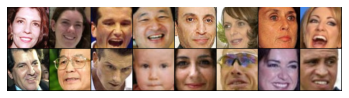

[[1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
tensor([[1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])


In [163]:
# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())
print(example_batch[2])


In [164]:
net = SiameseNetwork().cuda()

criterion = ContrastiveLoss()

optimizer = optim.Adam([
                {'params': net.model_vgg16.features[24:31].parameters()},                       
                {'params': net.model_vgg16.classifier.parameters()}
            ], lr=0.000005)

count_parameters(net)

The model architecture:

 SiameseNetwork(
  (model_vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    

In [165]:
save_path=os.path.join(path_lfw_folder,'siameseWithVGG16_best_val_acc.pt')

Starting epoch 1
Starting training... 
Starting validation... 
Model saved to ==> ./gdrive/MyDrive/Datasets/siameseWithVGG16_best_val_acc.pt
Epoch [1/30],Train Loss: 0.2676, Valid Loss: 0.24648275
Starting epoch 2
Starting training... 
Starting validation... 
Epoch [2/30],Train Loss: 0.2555, Valid Loss: 0.24665221
Starting epoch 3
Starting training... 
Starting validation... 
Model saved to ==> ./gdrive/MyDrive/Datasets/siameseWithVGG16_best_val_acc.pt
Epoch [3/30],Train Loss: 0.2543, Valid Loss: 0.24529081
Starting epoch 4
Starting training... 
Starting validation... 
Epoch [4/30],Train Loss: 0.2536, Valid Loss: 0.24512707
Starting epoch 5
Starting training... 
Starting validation... 
Epoch [5/30],Train Loss: 0.2528, Valid Loss: 0.24473293
Starting epoch 6
Starting training... 
Starting validation... 
Epoch [6/30],Train Loss: 0.2525, Valid Loss: 0.24505875
Starting epoch 7
Starting training... 
Starting validation... 
Epoch [7/30],Train Loss: 0.2520, Valid Loss: 0.24460132
Starting ep

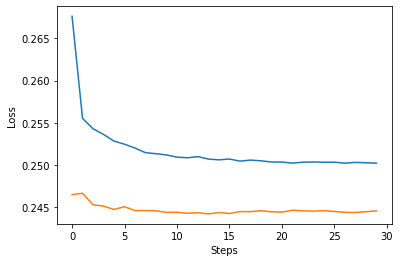

In [166]:
longest_trained_model,train_loss_his,val_loss_his,mx_val_accuracy_train,validation_accu=train(net,train_loader,val_loader,Config().train_number_epochs,criterion,save_path,optimizer)

In [167]:
# train_loss_his,val_loss_his,mx_val_accuracy_train,validation_accu=train(net,train_loader,val_loader,Config().train_number_epochs,criterion,save_path,optimizer)

In [168]:
save_checkpoint(os.path.join(path_lfw_folder,'siameseWithVGG16_longest_trained.pt'), longest_trained_model, optimizer, mx_val_accuracy_train)

Model saved to ==> ./gdrive/MyDrive/Datasets/siameseWithVGG16_longest_trained.pt


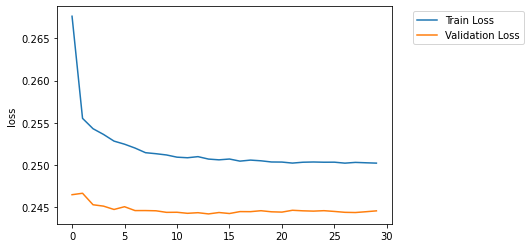

In [169]:
# lr=    batch=   epoch=
plt.ylabel('loss')
plt.plot(train_loss_his, label='Train Loss')
plt.plot(val_loss_his, label='Validation Loss')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

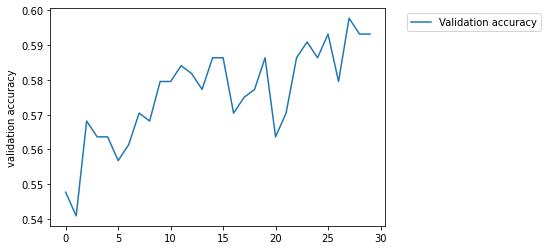

In [170]:
# lr=    batch=   epoch=
plt.ylabel('validation accuracy')
plt.plot(validation_accu, label='Validation accuracy')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [171]:
# def test(model,test_loader):
#     with torch.no_grad():
#       model.eval()
#       correct=0
#       cnt=0
#       bth_no=0
#       print("Strating ...")
#       for i,data in enumerate(test_loader,0):
#         bth_no+=1
#         print("Batch no: ",bth_no)
        
#         imgs1,imgs2,labels=data
        
#         imgs1=imgs1.to(device=device, dtype=torch.float)
#         imgs2=imgs2.to(device=device, dtype=torch.float)
#         labels=labels.to(device=device, dtype=torch.float)

#         output1,output2=model(imgs1,imgs2)

#         dist = F.pairwise_distance(output1, output2)     # dist will be a 1d array with each element representing dist for each pair  

#         noImg,noCrt= calculate_accuracy(labels,dist)
#         cnt+=noImg
#         correct+=noCrt

#     test_accuracy= correct/cnt
#     print("Finished!!!")

#     return test_accuracy


In [172]:
def test(model,test_loader):
    test_distances=[]
    test_labels=[]

    with torch.no_grad():
      model.eval()
      correct=0
      cnt=0
      for i,data in enumerate(test_loader,0):
        
        imgs1,imgs2,labels=data
        
        imgs1=imgs1.to(device=device, dtype=torch.float)
        imgs2=imgs2.to(device=device, dtype=torch.float)
        labels=labels.to(device=device, dtype=torch.float)

        output1,output2=model(imgs1,imgs2)

        dist = F.pairwise_distance(output1, output2)     # dist will be a 1d array with each element representing dist for each pair  

        test_distances.extend(dist)
        test_labels.extend(labels)

    return test_distances, test_labels

In [173]:
def generate_model_path(model_name):
  
  root_path_to_saved_models=path_lfw_folder
  path_to_model_from_saved_model_dir=model_name
  path_to_chosen_model= os.path.join(root_path_to_saved_models,path_to_model_from_saved_model_dir)  
  
  return path_to_chosen_model

def generate_optm_model():
  load_model= SiameseNetwork().cuda()
  load_optimizer = optim.Adam([
                {'params': load_model.model_vgg16.features[24:31].parameters()},                       
                {'params': load_model.model_vgg16.classifier.parameters()}
            ], lr=0.000005)                                              # set parameters and lr
  return load_model,load_optimizer

def generate_test_loader():
  siamese_dataset_test = SiameseNetworkDataset(Config().testing_txt,Config().testing_dir,
                                          transform=transforms.Compose([transforms.Resize(( 128,128 )),
                                                                        transforms.ToTensor()
                                                    ])
                                          )
  test_loader = DataLoader(siamese_dataset_test , shuffle=True, batch_size=1,  num_workers=2)

  return test_loader

def find_threshold(data_loader, thresholds, load_model):

  accuracies=[]
  print('Loading results...')
  test_distances, test_labels= test(load_model,data_loader)
  print('Finished loading results...')
  for threshold in thresholds:
    print("starting with threshold: ",threshold)
    noImg,noCrt= calculate_accuracy(test_labels,test_distances,threshold)
    accuracy= float(noCrt)/noImg
    accuracies.append(accuracy)
    print("finished with threshold: ",threshold)
  return accuracies

def cal_test_acc(data_loader, threshold, load_model):

  print('Loading results...')
  test_distances, test_labels= test(load_model,data_loader)
  print('Finished loading results...')

  noImg,noCrt= calculate_accuracy(test_labels,test_distances,threshold)
  
  return float(noCrt)/noImg

def plot_x_y(label,x,y,graph_label):
  plt.ylabel(label)

  plt.plot(x , y , label=graph_label)

  plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

  plt.show()

def find_max_accuracies(thresholds, accuracies, TYPE):
  mx_ac=-1
  mx_ind=-1

  for i in range(0,len(thresholds)):

    if mx_ac< accuracies[i]:
      mx_ac= accuracies[i]
      mx_ind=i

  print("Max ",TYPE," acc: ",mx_ac,"           Threshold: ",thresholds[mx_ind])

  return mx_ac, thresholds[mx_ind]

def Load_saved_model(model_name):
  
  load_model, load_optimizer= generate_optm_model()

  path_to_chosen_model= generate_model_path(model_name)

  load_checkpoint(load_model,load_optimizer,path_to_chosen_model)

  return load_model, load_optimizer


In [174]:
thresholds=[i for i in np.arange(0.0,2.0,0.01) ]

In [175]:
load_model, load_optimizer= Load_saved_model('siameseWithVGG16_best_val_acc.pt')

test_loader = generate_test_loader()

Model loaded from <== ./gdrive/MyDrive/Datasets/siameseWithVGG16_best_val_acc.pt


In [176]:
train_accuracies= find_threshold(train_loader , thresholds, load_model)
mx_train_acc, train_threshold = find_max_accuracies(thresholds, train_accuracies, 'train' )

Loading results...
Finished loading results...
starting with threshold:  0.0
finished with threshold:  0.0
starting with threshold:  0.01
finished with threshold:  0.01
starting with threshold:  0.02
finished with threshold:  0.02
starting with threshold:  0.03
finished with threshold:  0.03
starting with threshold:  0.04
finished with threshold:  0.04
starting with threshold:  0.05
finished with threshold:  0.05
starting with threshold:  0.06
finished with threshold:  0.06
starting with threshold:  0.07
finished with threshold:  0.07
starting with threshold:  0.08
finished with threshold:  0.08
starting with threshold:  0.09
finished with threshold:  0.09
starting with threshold:  0.1
finished with threshold:  0.1
starting with threshold:  0.11
finished with threshold:  0.11
starting with threshold:  0.12
finished with threshold:  0.12
starting with threshold:  0.13
finished with threshold:  0.13
starting with threshold:  0.14
finished with threshold:  0.14
starting with threshold:  0

In [177]:
test_accuracy= cal_test_acc(test_loader,train_threshold, load_model)

Loading results...
Finished loading results...


Maximum train accuracy:  0.6460227272727272  at threshold:  0.5
Test accuracy:  0.579  at threshold:  0.5


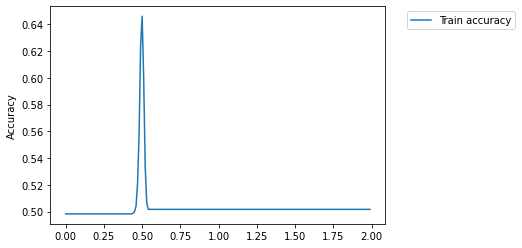

In [178]:
print("Maximum train accuracy: ",mx_train_acc," at threshold: ",train_threshold)
print("Test accuracy: ",test_accuracy," at threshold: ",train_threshold)

plot_x_y('Accuracy',thresholds,train_accuracies,'Train accuracy')

In [179]:
# root_path_to_saved_models=path_lfw_folder
# path_to_model_from_saved_model_dir='siameseWithVGG16.pt'
# path_to_chosen_model= os.path.join(root_path_to_saved_models,path_to_model_from_saved_model_dir)  #################
# # print(path_to_chosen_model )

In [180]:
# load_model= SiameseNetwork().cuda()
# load_optimizer = optim.Adam([
#                 {'params': load_model.model_vgg16.features[24:31].parameters()},                    
#                 {'params': load_model.model_vgg16.classifier.parameters()}
#             ], lr=0.000005)
# mx_val_acc=load_checkpoint(load_model,load_optimizer,path_to_chosen_model)



# siamese_dataset_test = SiameseNetworkDataset(Config().testing_txt,Config().testing_dir,
#                                         transform=transforms.Compose([transforms.Resize(( 128,128 )),
#                                                                       transforms.ToTensor()
#                                                   ])
#                                         )
# test_loader = DataLoader(siamese_dataset_test , shuffle=True, batch_size=1,  num_workers=2)

# train_accuracy= test(load_model,train_loader)
# test_accuracy=test(load_model,test_loader)


# print("Train accuracy is: ",100*train_accuracy)
# print("Test accuracy is: ",100*test_accuracy)
# print("Max val accuracy during training: ",100*mx_val_acc)

In [181]:
# print("Train accuracy is: ",100*train_accuracy)
# print("Test accuracy is: ",100*test_accuracy)
# print("Max val accuracy during training: ",100*mx_val_acc)

Longest trained model

In [182]:
load_model, load_optimizer= Load_saved_model('siameseWithVGG16_longest_trained.pt')

test_loader = generate_test_loader()

Model loaded from <== ./gdrive/MyDrive/Datasets/siameseWithVGG16_longest_trained.pt


In [183]:
train_accuracies= find_threshold(train_loader , thresholds, load_model)
mx_train_acc, train_threshold = find_max_accuracies(thresholds, train_accuracies, 'train' )

Loading results...
Finished loading results...
starting with threshold:  0.0
finished with threshold:  0.0
starting with threshold:  0.01
finished with threshold:  0.01
starting with threshold:  0.02
finished with threshold:  0.02
starting with threshold:  0.03
finished with threshold:  0.03
starting with threshold:  0.04
finished with threshold:  0.04
starting with threshold:  0.05
finished with threshold:  0.05
starting with threshold:  0.06
finished with threshold:  0.06
starting with threshold:  0.07
finished with threshold:  0.07
starting with threshold:  0.08
finished with threshold:  0.08
starting with threshold:  0.09
finished with threshold:  0.09
starting with threshold:  0.1
finished with threshold:  0.1
starting with threshold:  0.11
finished with threshold:  0.11
starting with threshold:  0.12
finished with threshold:  0.12
starting with threshold:  0.13
finished with threshold:  0.13
starting with threshold:  0.14
finished with threshold:  0.14
starting with threshold:  0

In [184]:
test_accuracy= cal_test_acc(test_loader,train_threshold, load_model)

Loading results...
Finished loading results...


Maximum train accuracy:  0.6460227272727272  at threshold:  0.5
Test accuracy:  0.584  at threshold:  0.5


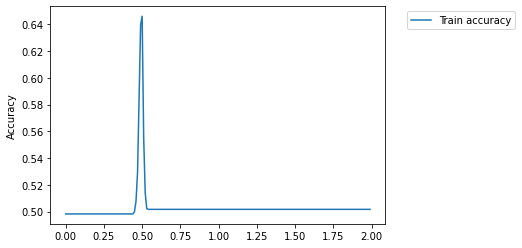

In [185]:
print("Maximum train accuracy: ",mx_train_acc," at threshold: ",train_threshold)
print("Test accuracy: ",test_accuracy," at threshold: ",train_threshold)

plot_x_y('Accuracy',thresholds,train_accuracies,'Train accuracy')

In [186]:
print("Done")

Done
